<a href="https://colab.research.google.com/github/Ridhi655/Resume-Screening-with-Natural-Language-Processing-in-Python/blob/main/Resume_Screening_with_Natural_Language_Processing_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Loading Libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving UpdatedResumeDataSet.csv to UpdatedResumeDataSet (1).csv


In [ ]:
resumeDataSet = pd.read_csv('UpdatedResumeDataSet.csv', encoding='utf-8')


**Exploratory Data Analysis**

Let’s have a quick view of the data we have.

In [ ]:
resumeDataSet.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


There are only two columns we have in the data. Below is the definition of each column.

Category: Type of Job Resume fits for.

Resume: Resume of candidates

In [ ]:
resumeDataSet.shape

(962, 2)

There are 962 observations we have in the data. Each observation represents the complete details of each candidate so we have 962 resumes for screening.

Let’s see what different categories we have in the data.

In [ ]:
resumeDataSet['Category'].value_counts()

,count
Category,
Java Developer,84
Testing,70
DevOps Engineer,55
Python Developer,48
Web Designing,45
HR,44
Hadoop,42
Sales,40
Data Science,40


There are 25 different categories we have in the data.  The top 3 job categories we have in the data are as follows.

Java developer, Testing, and DevOps Engineer.

Instead of the count or frequency, we can also visualize the distribution of job categories in percentage as below:

In [44]:
import seaborn as sns

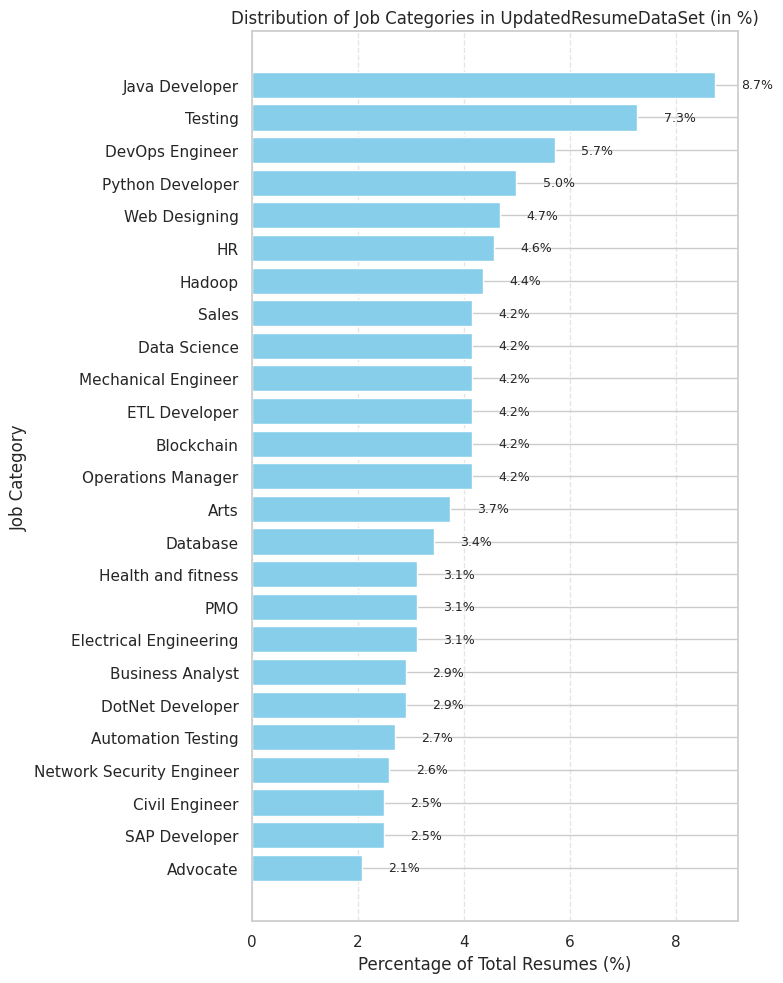

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load your dataset
resumeDataSet = pd.read_csv('UpdatedResumeDataSet.csv', encoding='utf-8')

# 2. Compute counts and percentages
counts = resumeDataSet['Category'].value_counts()
percentages = counts / counts.sum() * 100

# 3. (Optional) If you only want, say, the top 15 categories:
# percentages = percentages.head(15)

# 4. Plot
fig, ax = plt.subplots(figsize=(8, 10))
bars = ax.barh(percentages.index, percentages.values, color='skyblue')

# 5. Invert y-axis so the largest bars appear at the top
ax.invert_yaxis()

# 6. Annotate each bar with its percent value
for bar in bars:
    pct = bar.get_width()
    ax.text(
        pct + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f"{pct:.1f}%",
        va='center',
        fontsize=9
    )

# 7. Labels, title, grid, layout
ax.set_xlabel('Percentage of Total Resumes (%)')
ax.set_ylabel('Job Category')
ax.set_title('Distribution of Job Categories in UpdatedResumeDataSet (in %)')
ax.xaxis.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


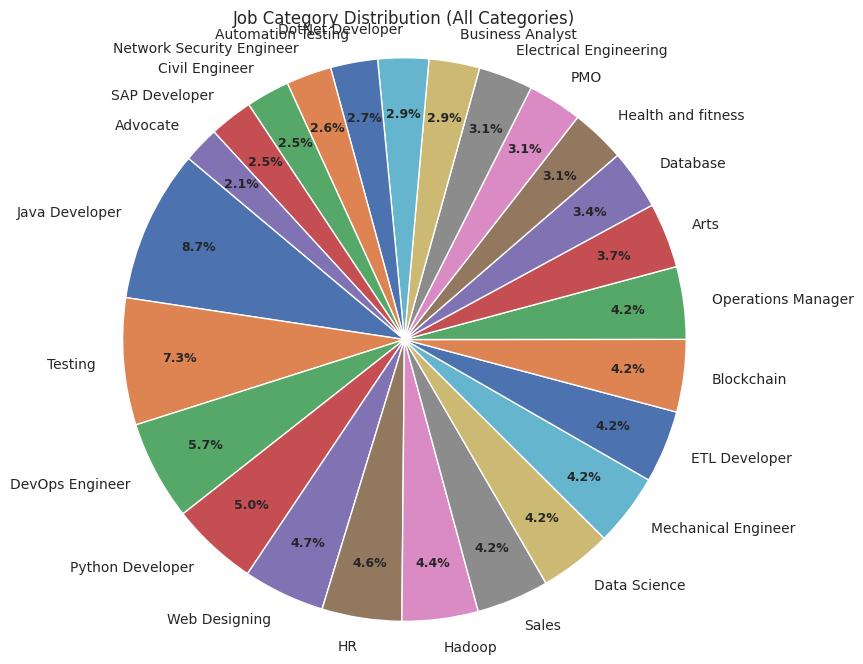

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load your dataset
resumeDataSet = pd.read_csv('UpdatedResumeDataSet.csv', encoding='utf-8')

# 2. Compute counts and percentages
counts = resumeDataSet['Category'].value_counts()
percentages = counts / counts.sum() * 100

# 3. Plot the pie chart for all categories
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    percentages.values,
    labels=percentages.index,
    autopct='%1.1f%%',
    startangle=140,
    pctdistance=0.8
)

# 4. Equal aspect ratio ensures pie is drawn as a circle
ax.axis('equal')

# 5. Title
ax.set_title('Job Category Distribution (All Categories)')

# 6. Improve label font size
plt.setp(texts, size=10)
plt.setp(autotexts, size=9, weight='bold')

plt.show()


**Data Preprocessing**

**Step 1: Clean the ‘Resume’ column**

In this step, we remove any unnecessary information from resumes like URLs, hashtags, and special characters.

In [56]:

def cleanResume(resumeText):
    resumeText = re.sub('httpS+s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^x00-x7f]',r' ', resumeText)
    resumeText = re.sub('s+', ' ', resumeText)  # remove extra whitespace
    return resumeText
resumeDataSet['cleaned_resume'] = resumeDataSet.Resume.apply(lambda x: cleanResume(x))


**Step 2: Encoding ‘Category’**

Now, we will encode the ‘Category’ column using LabelEncoding. Even though the ‘Category’ column is ‘Nominal’ data we are using LabelEncong because the ‘Category’ column is our ‘target’ column. By performing LabelEncoding each category will become a class and we will be building a multiclass classification model.

In [57]:
var_mod = ['Category']
le = LabelEncoder()
for i in var_mod:
    resumeDataSet[i] = le.fit_transform(resumeDataSet[i])


**Step 3: Preprocessing ‘cleaned_resume’ column**

Here we will preprocess and convert the ‘cleaned_resume’ column into vectors. There are many ways to do that like ‘Bag of Words’, ‘Tf-Idf’, ‘Word2Vec’ and a combination of these methods.

We will be using the ‘Tf-Idf’ method to get the vectors in this approach.

In [58]:
requiredText = resumeDataSet['cleaned_resume'].values
requiredTarget = resumeDataSet['Category'].values
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=1500)
word_vectorizer.fit(requiredText)
WordFeatures = word_vectorizer.transform(requiredText)

We have ‘WordFeatures’ as vectors and ‘requiredTarget’ and target after this step.



**Model Building**

We will be using the ‘One vs Rest’ method with ‘KNeighborsClassifier’ to build this multiclass classification model.

We will use 80% data for training and 20% data for validation. Let’s split the data now into training and test set.

In [59]:
#Model Building
X_train,X_test,y_train,y_test = train_test_split(WordFeatures,requiredTarget,random_state=0, test_size=0.2)
print(X_train.shape)
print(X_test.shape)


(769, 1500)
(193, 1500)


Since now we have train and test data let’s build the model.

In [60]:
clf = OneVsRestClassifier(KNeighborsClassifier())
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

**Results**

Let see the results we have..

In [61]:
#Results
print('Accuracy of KNeighbors Classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of KNeighbors Classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))


Accuracy of KNeighbors Classifier on training set: 0.99
Accuracy of KNeighbors Classifier on test set: 0.99


We can see that results are awesome. We are able to classify each Category of a given resume with 99% accuracy.

We can also check the detailed classification report for each class or category.

In [62]:
print("n Classification report for classifier %s:n%sn" % (clf, metrics.classification_report(y_test, prediction)))

n Classification report for classifier OneVsRestClassifier(estimator=KNeighborsClassifier()):n              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         7
           8       1.00      0.91      0.95        11
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00         8
          11       0.90      1.00      0.95         9
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         9
          14       1.00      1.00      1.00         7
          15       1.00      1.00      1.

Where, 0, 1, 2…. are the job categories. We get the actual labels from the label encoder that we used.

In [63]:
le.classes_

array(['Advocate', 'Arts', 'Automation Testing', 'Blockchain',
       'Business Analyst', 'Civil Engineer', 'Data Science', 'Database',
       'DevOps Engineer', 'DotNet Developer', 'ETL Developer',
       'Electrical Engineering', 'HR', 'Hadoop', 'Health and fitness',
       'Java Developer', 'Mechanical Engineer',
       'Network Security Engineer', 'Operations Manager', 'PMO',
       'Python Developer', 'SAP Developer', 'Sales', 'Testing',
       'Web Designing'], dtype=object)

**Conclusion**

We learned how machine learning and Natural Language Processing can be applied to improve our day-to-day life through the example of Resume Screening. We just classified almost 1000 resumes in few minutes into their respective categories with 99% accuracy.